In [1]:
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import cartopy
from datetime import datetime, timedelta
import os
import numpy as np

In [2]:
grid_path = r'Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/data_adapted_condition_0.02_20_all/Auxillary/grid_2d.h5'

In [3]:
rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='10m')
border = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
lon_model = np.flipud(h5py.File(grid_path,'r')['lon'][:, :])
lat_model = np.flipud(h5py.File(grid_path,'r')['lat'][:, :])

In [4]:

# Define intervals and colors
vmin, vmax = 0, 154
intervals = [vmin, 0.2, 0.3, 0.6, 0.9, 1.7, 2.7, 5, 8.6, 15, 27.3, 50, 89.9, vmax]
colors = ['#fffffe', '#0101ff', '#0153ff', '#00acfe', '#01feff',
          '#8cff8c', '#fffe01', '#ff8d01', '#fe4300', '#f60100',
          '#bc0030', '#ad01ac', '#ff00ff']

# Create custom colormap and normalization
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
custom_norm = BoundaryNorm(intervals, custom_cmap.N)

In [5]:
def plot_precip_comparison(model_dir, imerg_final_dir, imerg_early_dir, date, time_range, version_early, lat_bounds=None, lon_bounds=None):
    """
    Plots IMERG-Final, IMERG-Early, and model output data for a specific date and time range.

    Parameters:
        model_dir (str): Path to the directory containing model output files.
        imerg_final_dir (str): Path to the directory containing IMERG-Final data.
        imerg_early_dir (str): Path to the directory containing IMERG-Early data.
        date (str): Date in 'YYYYMMDD' format.
        time_range (tuple): Time range as (start_hour, end_hour) in 24-hour format.
        lat_bounds (tuple): Latitude boundaries as (min_lat, max_lat).
        lon_bounds (tuple): Longitude boundaries as (min_lon, max_lon).
    """
    # Define time range
    start_time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=time_range[0])
    end_time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=time_range[1])

    # Generate the list of hourly timestamps within the range
    timestamps = [start_time + timedelta(hours=i) for i in range(time_range[1] - time_range[0] + 1)]

    # Initialize the plot
    num_timestamps = len(timestamps)
    fig, axes = plt.subplots(3, num_timestamps, figsize=(5 * num_timestamps, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(f"Precipitation Comparison for {date}", fontsize=16)

    def time_to_minutes(time_str):
        time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
        minutes = time_obj.hour * 60 + time_obj.minute - 30
        if minutes <= 0:
            minutes = '0000'

        elif minutes < 100 and minutes > 0:
            minutes = '00' + f'{minutes}'

        elif minutes < 1000 and minutes > 100:
            minutes = '0'+ f'{minutes}'

        elif minutes > 1000:
            minutes = f'{minutes}'
        return minutes


    def plot_data(ax, file_path, dataset_path, cmap, norm, title, lat_bounds=lat_bounds, lon_bounds=lon_bounds):
        if not os.path.exists(file_path):
            ax.set_title("No Data")
            return None
    
        with h5py.File(file_path, 'r') as f:
            try:
                # Extract data, latitude, and longitude
                data = f[dataset_path][:]
                lon = f['Grid/lon'][:]
                lat = f['Grid/lat'][:]
    
                # Ensure data is squeezed to 2D (remove extra dimensions)
                data = np.flipud(np.squeeze(data.T))
    
                # Handle coordinate mismatch for pcolormesh
                if lon.ndim == 1 and lat.ndim == 1:
                    lon, lat = np.meshgrid(lon, lat)  # Create 2D coordinate arrays
                    lat = np.flipud(lat)
    
                # Plot the data
                mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')
    
                # Set extent if bounds are provided
                if lat_bounds and lon_bounds:
                    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    
                # Add map features
                ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
                ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                ax.set_title(title)
                return mesh
    
            except KeyError:
                ax.set_title("Variable Not Found")
                return None

            
    def plot_data_model(ax, file_path, variable_name, cmap, norm, title):
        if os.path.exists(file_path):
            ds = xr.open_dataset(file_path, engine='netcdf4')
            data = np.flipud(np.squeeze(ds[variable_name].values))
            lon =lon_model
            lat = lat_model
            mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            ax.set_title(title)
            return mesh
        else:
            ax.set_title("No Data")

    mesh = None

    for col, timestamp in enumerate(timestamps):
        # Extract timestamp details
        hour_str = timestamp.strftime('%H')
        imerg_time = timestamp - timedelta(hours=1)
        imerg_hour = imerg_time.strftime('%H')
        minutes = time_to_minutes(timestamp.strftime("%Y-%m-%d %H:%M:%S"))
        

        # Generate IMERG-Final file path
        imerg_final_file = os.path.join(
            imerg_final_dir,
            timestamp.strftime('%Y/%m/%d'),
            f"3B-HHR.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}5959.{minutes}.V07B.HDF5"
        )

        # Generate IMERG-Early file path
        imerg_early_file = os.path.join(
            imerg_early_dir,
            timestamp.strftime('%Y/%m/%d'),
            f"3B-HHR-E.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}5959.{minutes}.V06{version_early}.HDF5"
        )

        # Generate model output file path
        model_file = os.path.join(model_dir, f"Combined_{(timestamp - timedelta(seconds = 1)).strftime('%Y%m%d%H%M%S')}.h.h5")

        # Plot IMERG-Final (row 0)
        mesh = plot_data(axes[0, col], imerg_final_file, 'Grid/precipitation', custom_cmap, custom_norm, f"IMERG-Final {hour_str}h") or mesh

        # Plot IMERG-Early (row 1)
        mesh = plot_data(axes[1, col], imerg_early_file, 'Grid/precipitationCal', custom_cmap, custom_norm, f"IMERG-Early {hour_str}h") or mesh

        # Plot model output (row 2)
        mesh = plot_data_model(axes[2, col], model_file, 'y_hat', custom_cmap, custom_norm, f"Earthformer {hour_str}h") or mesh

    # Add a single colorbar for the entire plot if mesh is valid
    if mesh:
        cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Precipitation (mm/hr)')

    # Show the plot
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])
    plt.show()

In [6]:
def plot_precip_comparison_full(model_dir, model_dir2, imerg_final_dir, imerg_early_dir, date, time_range, version_early, lat_bounds=None, lon_bounds=None):
    """
    Plots IMERG-Final, IMERG-Early, and model output data for a specific date and time range.

    Parameters:
        model_dir (str): Path to the directory containing model output files.
        imerg_final_dir (str): Path to the directory containing IMERG-Final data.
        imerg_early_dir (str): Path to the directory containing IMERG-Early data.
        date (str): Date in 'YYYYMMDD' format.
        time_range (tuple): Time range as (start_hour, end_hour) in 24-hour format.
        lat_bounds (tuple): Latitude boundaries as (min_lat, max_lat).
        lon_bounds (tuple): Longitude boundaries as (min_lon, max_lon).
    """
    # Define time range
    start_time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=time_range[0])
    end_time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=time_range[1])

    # Generate the list of hourly timestamps within the range
    timestamps = [start_time + timedelta(hours=i) for i in range(time_range[1] - time_range[0] + 1)]

    # Initialize the plot
    num_timestamps = len(timestamps)
    fig, axes = plt.subplots(4, num_timestamps, figsize=(5 * num_timestamps, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(f"Precipitation Comparison for {date}", fontsize=16)

    def time_to_minutes(time_str):
        time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
        minutes = time_obj.hour * 60 + time_obj.minute - 30
        if minutes <= 0:
            minutes = '0000'

        elif minutes < 100 and minutes > 0:
            minutes = '00' + f'{minutes}'

        elif minutes < 1000 and minutes > 100:
            minutes = '0'+ f'{minutes}'

        elif minutes > 1000:
            minutes = f'{minutes}'
        return minutes


    def plot_data(ax, file_path, dataset_path, cmap, norm, title, lat_bounds=lat_bounds, lon_bounds=lon_bounds):
        if not os.path.exists(file_path):
            ax.set_title("No Data")
            return None
    
        with h5py.File(file_path, 'r') as f:
            try:
                # Extract data, latitude, and longitude
                data = f[dataset_path][:]
                lon = f['Grid/lon'][:]
                lat = f['Grid/lat'][:]
    
                # Ensure data is squeezed to 2D (remove extra dimensions)
                data = np.flipud(np.squeeze(data.T))
    
                # Handle coordinate mismatch for pcolormesh
                if lon.ndim == 1 and lat.ndim == 1:
                    lon, lat = np.meshgrid(lon, lat)  # Create 2D coordinate arrays
                    lat = np.flipud(lat)
    
                # Plot the data
                mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')
    
                # Set extent if bounds are provided
                if lat_bounds and lon_bounds:
                    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    
                # Add map features
                ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
                ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                ax.set_title(title)
                return mesh
    
            except KeyError:
                ax.set_title("Variable Not Found")
                return None

            
    def plot_data_model(ax, file_path, variable_name, cmap, norm, title):
        if os.path.exists(file_path):
            ds = xr.open_dataset(file_path, engine='netcdf4')
            data = np.flipud(np.squeeze(ds[variable_name].values))
            lon =lon_model
            lat = lat_model
            mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            ax.set_title(title)
            return mesh
        else:
            ax.set_title("No Data")

    mesh = None

    for col, timestamp in enumerate(timestamps):
        # Extract timestamp details
        hour_str = timestamp.strftime('%H')
        imerg_time = timestamp - timedelta(hours=1)
        imerg_hour = imerg_time.strftime('%H')
        minutes = time_to_minutes(timestamp.strftime("%Y-%m-%d %H:%M:%S"))
        

        # Generate IMERG-Final file path
        imerg_final_file = os.path.join(
            imerg_final_dir,
            timestamp.strftime('%Y/%m/%d'),
            f"3B-HHR.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}5959.{minutes}.V07B.HDF5"
        )

        # Generate IMERG-Early file path
        imerg_early_file = os.path.join(
            imerg_early_dir,
            timestamp.strftime('%Y/%m/%d'),
            f"3B-HHR-E.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}5959.{minutes}.V06{version_early}.HDF5"
        )

        print(imerg_final_file)
        print(imerg_early_file)

        # Generate model output file path
        model_file1 = os.path.join(model_dir, f"Combined_{(timestamp - timedelta(seconds = 1)).strftime('%Y%m%d%H%M%S')}.h.h5")

        model_file2 = os.path.join(model_dir2, f"Combined_{(timestamp - timedelta(seconds = 1)).strftime('%Y%m%d%H%M%S')}.h.h5")

        # Plot IMERG-Final (row 0)
        mesh = plot_data(axes[0, col], imerg_final_file, 'Grid/precipitation', custom_cmap, custom_norm, f"IMERG-Final {hour_str}h") or mesh

        # Plot IMERG-Early (row 1)
        mesh = plot_data(axes[1, col], imerg_early_file, 'Grid/precipitationCal', custom_cmap, custom_norm, f"IMERG-Early {hour_str}h") or mesh

        # Plot model output (row 2)
        mesh = plot_data_model(axes[2, col], model_file1, 'y_hat', custom_cmap, custom_norm, f"Earthformer MSE{hour_str}h") or mesh

        # Plot model output (row 2)
        mesh = plot_data_model(axes[3, col], model_file2, 'y_hat', custom_cmap, custom_norm, f"Earthformer Balanced{hour_str}h") or mesh

    # Add a single colorbar for the entire plot if mesh is valid
    if mesh:
        cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Precipitation (mm/hr)', fontsize = 35)
        cbar.set_ticks(intervals)  # Explicitly set tick positions
        cbar.set_ticklabels([str(i) for i in intervals])  # Ensure all labels appear
        

    # Show the plot
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])

    plt.savefig(f'event_{timestamp.strftime("%Y%m%d%H%M%S")}.png')
    plt.show()

In [7]:
def plot_precip_comparison_full_half(model_dir, model_dir2, imerg_final_dir, imerg_early_dir, date, time_range, version_early, lat_bounds=None, lon_bounds=None):
    """
    Plots IMERG-Final, IMERG-Early, and model output data for a specific date and time range.

    Parameters:
        model_dir (str): Path to the directory containing model output files.
        imerg_final_dir (str): Path to the directory containing IMERG-Final data.
        imerg_early_dir (str): Path to the directory containing IMERG-Early data.
        date (str): Date in 'YYYYMMDD' format.
        time_range (tuple): Time range as (start_hour, end_hour) in 24-hour format.
        lat_bounds (tuple): Latitude boundaries as (min_lat, max_lat).
        lon_bounds (tuple): Longitude boundaries as (min_lon, max_lon).
    """
    # Define time range
    start_time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=time_range[0]) + timedelta(minutes = 30)
    end_time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=time_range[1]) + timedelta(minutes = 30)

    # Generate the list of hourly timestamps within the range
    timestamps = [start_time + timedelta(hours=i) for i in range(time_range[1] - time_range[0] + 1)]

    # Initialize the plot
    num_timestamps = len(timestamps)
    fig, axes = plt.subplots(4, num_timestamps, figsize=(5 * num_timestamps, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(f"Precipitation Comparison for {date}", fontsize=16)

    def time_to_minutes(time_str):
        time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
        minutes = time_obj.hour * 60 + time_obj.minute - 30
        if minutes <= 0:
            minutes = '0000'

        elif minutes < 100 and minutes > 0:
            minutes = '00' + f'{minutes}'

        elif minutes < 1000 and minutes > 100:
            minutes = '0'+ f'{minutes}'

        elif minutes > 1000:
            minutes = f'{minutes}'
        return minutes


    def plot_data(ax, file_path, dataset_path, cmap, norm, title, lat_bounds=lat_bounds, lon_bounds=lon_bounds):
        if not os.path.exists(file_path):
            ax.set_title("No Data")
            return None
    
        with h5py.File(file_path, 'r') as f:
            try:
                # Extract data, latitude, and longitude
                data = f[dataset_path][:]
                lon = f['Grid/lon'][:]
                lat = f['Grid/lat'][:]
    
                # Ensure data is squeezed to 2D (remove extra dimensions)
                data = np.flipud(np.squeeze(data.T))
    
                # Handle coordinate mismatch for pcolormesh
                if lon.ndim == 1 and lat.ndim == 1:
                    lon, lat = np.meshgrid(lon, lat)  # Create 2D coordinate arrays
                    lat = np.flipud(lat)
    
                # Plot the data
                mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')
    
                # Set extent if bounds are provided
                if lat_bounds and lon_bounds:
                    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    
                # Add map features
                ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
                ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                ax.set_title(title)
                return mesh
    
            except KeyError:
                ax.set_title("Variable Not Found")
                return None

            
    def plot_data_model(ax, file_path, variable_name, cmap, norm, title):
        if os.path.exists(file_path):
            ds = xr.open_dataset(file_path, engine='netcdf4')
            data = np.flipud(np.squeeze(ds[variable_name].values))
            lon =lon_model
            lat = lat_model
            mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
            ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            ax.set_title(title)
            return mesh
        else:
            ax.set_title("No Data")

    mesh = None

    for col, timestamp in enumerate(timestamps):
        # Extract timestamp details
        hour_str = timestamp.strftime('%H')
        imerg_time = timestamp - timedelta(hours=1)
        imerg_hour = imerg_time.strftime('%H')
        minutes = time_to_minutes(timestamp.strftime("%Y-%m-%d %H:%M:%S"))
        

        # Generate IMERG-Final file path
        imerg_final_file = os.path.join(
            imerg_final_dir,
            timestamp.strftime('%Y/%m/%d'),
            f"3B-HHR.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}2959.{minutes}.V07B.HDF5"
        )

        # Generate IMERG-Early file path
        imerg_early_file = os.path.join(
            imerg_early_dir,
            timestamp.strftime('%Y/%m/%d'),
            f"3B-HHR-E.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}2959.{minutes}.V06{version_early}.HDF5"
        )

        # Generate model output file path
        model_file1 = os.path.join(model_dir, f"Combined_{(timestamp - timedelta(seconds = 1)).strftime('%Y%m%d%H%M%S')}.h.h5")

        model_file2 = os.path.join(model_dir2, f"Combined_{(timestamp - timedelta(seconds = 1)).strftime('%Y%m%d%H%M%S')}.h.h5")

        # Plot IMERG-Final (row 0)
        mesh = plot_data(axes[0, col], imerg_final_file, 'Grid/precipitation', custom_cmap, custom_norm, f"IMERG-Final {hour_str}h") or mesh

        # Plot IMERG-Early (row 1)
        mesh = plot_data(axes[1, col], imerg_early_file, 'Grid/precipitationCal', custom_cmap, custom_norm, f"IMERG-Early {hour_str}h") or mesh

        # Plot model output (row 2)
        mesh = plot_data_model(axes[2, col], model_file1, 'y_hat', custom_cmap, custom_norm, f"Earthformer MSE{hour_str}h") or mesh

        # Plot model output (row 2)
        mesh = plot_data_model(axes[3, col], model_file2, 'y_hat', custom_cmap, custom_norm, f"Earthformer Balanced{hour_str}h") or mesh

    # Add a single colorbar for the entire plot if mesh is valid
    if mesh:
        cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Precipitation (mm/hr)')

    # Show the plot
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])

    plt.savefig(f'event_{timestamp.strftime("%Y%m%d%H%M%S")}.png')
    plt.show()

In [8]:
def plot_precip_comparison_single(model_dir, model_dir2, imerg_final_dir, imerg_early_dir, date, hour, version_early, lat_bounds=None, lon_bounds=None):
    """
    Plots IMERG-Final, IMERG-Early, and model output data for a specific date and hour.

    Parameters:
        model_dir (str): Path to the directory containing model output files.
        model_dir2 (str): Path to the second model directory.
        imerg_final_dir (str): Path to the directory containing IMERG-Final data.
        imerg_early_dir (str): Path to the directory containing IMERG-Early data.
        date (str): Date in 'YYYYMMDD' format.
        hour (int): Hour in 24-hour format.
        version_early (str): IMERG Early version suffix.
        lat_bounds (tuple): Latitude boundaries as (min_lat, max_lat).
        lon_bounds (tuple): Longitude boundaries as (min_lon, max_lon).
    """
    timestamp = datetime.strptime(date, '%Y%m%d') + timedelta(hours=hour)
    imerg_time = timestamp - timedelta(hours=1)
    imerg_hour = imerg_time.strftime('%H')

    # def time_to_minutes(time_str):
    #     time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
    #     minutes = time_obj.hour * 60 + time_obj.minute - 30
    #     return f'{minutes:04d}' if minutes > 0 else '0000'

    def time_to_minutes(time_str):
        time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
        minutes = time_obj.hour * 60 + time_obj.minute - 30
        if minutes <= 0:
            minutes = '0000'

        elif minutes < 100 and minutes > 0:
            minutes = '00' + f'{minutes}'

        elif minutes < 1000 and minutes > 100:
            minutes = '0'+ f'{minutes}'

        elif minutes > 1000:
            minutes = f'{minutes}'
        return minutes

    minutes = time_to_minutes(timestamp.strftime("%Y-%m-%d %H:%M:%S"))

    imerg_final_file = os.path.join(
        imerg_final_dir,
        timestamp.strftime('%Y/%m/%d'),
        f"3B-HHR.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}5959.{minutes}.V07B.HDF5"
    )

    imerg_early_file = os.path.join(
        imerg_early_dir,
        timestamp.strftime('%Y/%m/%d'),
        f"3B-HHR-E.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}3000-E{imerg_hour}5959.{minutes}.V07{version_early}.HDF5"
    )

    model_file1 = os.path.join(model_dir, f"Combined_{(timestamp - timedelta(seconds=1)).strftime('%Y%m%d%H%M%S')}.h.h5")
    model_file2 = os.path.join(model_dir2, f"Combined_{(timestamp - timedelta(seconds=1)).strftime('%Y%m%d%H%M%S')}.h.h5")

    fig, axes = plt.subplots(4, 1, figsize=(5, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    #fig.suptitle(f"Precipitation Comparison for {date} {hour:02d}:00 UTC", fontsize=16)

    # def plot_data(ax, file_path, dataset_path, cmap, norm, title):
    #     if not os.path.exists(file_path):
    #         ax.set_title("No Data")
    #         return None
        
    #     with h5py.File(file_path, 'r') as f:
    #         try:
    #             data = f[dataset_path][:]
    #             lon = f['Grid/lon'][:]
    #             lat = f['Grid/lat'][:]

    #             data = np.flipud(np.squeeze(data.T))
    #             lon, lat = np.meshgrid(lon, lat)

    #             mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')

    #             if lat_bounds and lon_bounds:
    #                 ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    #             ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    #             ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    #             ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    #             ax.set_title(title)
    #             return mesh
    #         except KeyError:
    #             ax.set_title("Variable Not Found")
    #             return None

    def plot_data(ax, file_path, dataset_path, cmap, norm, title, lat_bounds=lat_bounds, lon_bounds=lon_bounds):
        if not os.path.exists(file_path):
            ax.set_title("No Data")
            return None
    
        with h5py.File(file_path, 'r') as f:
            try:
                # Extract data, latitude, and longitude
                data = f[dataset_path][:]
                lon = f['Grid/lon'][:]
                lat = f['Grid/lat'][:]
    
                # Ensure data is squeezed to 2D (remove extra dimensions)
                data = np.flipud(np.squeeze(data.T))
    
                # Handle coordinate mismatch for pcolormesh
                if lon.ndim == 1 and lat.ndim == 1:
                    lon, lat = np.meshgrid(lon, lat)  # Create 2D coordinate arrays
                    lat = np.flipud(lat)
    
                # Plot the data
                mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')
    
                # Set extent if bounds are provided
                if lat_bounds and lon_bounds:
                    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    
                # Add map features
                ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
                ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
                # Customize gridline label font size and padding
                gl.top_labels = False
                gl.right_labels = False
                gl.xlabel_style = {'size': 25, 'rotation': 0}  # Longitude label style
                gl.ylabel_style = {'size': 25, 'rotation': 0}
                ax.set_title(title, fontsize = 30)
                return mesh
    
            except KeyError:
                ax.set_title("Variable Not Found")
                return None

    

    def plot_data_model(ax, file_path, variable_name, cmap, norm, title):
        if not os.path.exists(file_path):
            ax.set_title("No Data")
            return None
        
        ds = xr.open_dataset(file_path, engine='netcdf4')
        data = np.flipud(np.squeeze(ds[variable_name].values))
        lon = lon_model
        lat = lat_model

        mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Customize gridline label font size and padding
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 25, 'rotation': 0}  # Longitude label style
        gl.ylabel_style = {'size': 25, 'rotation': 0}
        ax.set_title(title, fontsize = 30)
        ax.set_title(title, fontsize = 30)
        return mesh

    mesh = plot_data(axes[0], imerg_final_file, 'Grid/precipitation', custom_cmap, custom_norm, f"IMERG-Final") or mesh
    mesh = plot_data(axes[1], imerg_early_file, 'Grid/precipitationCal', custom_cmap, custom_norm, f"IMERG-Early") or mesh
    mesh = plot_data_model(axes[2], model_file1, 'y_hat', custom_cmap, custom_norm, f"Earthformer MSE") or mesh
    mesh = plot_data_model(axes[3], model_file2, 'y_hat', custom_cmap, custom_norm, f"Earthformer Balanced") or mesh

    if mesh:
        cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust as needed
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', ticks=intervals)
        cbar.set_label('Precipitation (mm/hr)', fontsize = 25)
        cbar.set_ticks(intervals)  # Explicitly set tick positions
        cbar.set_ticklabels([str(i) for i in intervals])  # Ensure all labels appear

    plt.tight_layout(rect=[0, 0.15, 1, 0.95])
    plt.savefig(f'event_{timestamp.strftime("%Y%m%d%H%M%S")}.png')
    plt.show()

In [12]:
def plot_precip_comparison_single_halfhour(model_dir, model_dir2, imerg_final_dir, imerg_early_dir, date, hour, version_early, lat_bounds=None, lon_bounds=None):
    """
    Plots IMERG-Final, IMERG-Early, and model output data for a specific date and hour.

    Parameters:
        model_dir (str): Path to the directory containing model output files.
        model_dir2 (str): Path to the second model directory.
        imerg_final_dir (str): Path to the directory containing IMERG-Final data.
        imerg_early_dir (str): Path to the directory containing IMERG-Early data.
        date (str): Date in 'YYYYMMDD' format.
        hour (int): Hour in 24-hour format.
        version_early (str): IMERG Early version suffix.
        lat_bounds (tuple): Latitude boundaries as (min_lat, max_lat).
        lon_bounds (tuple): Longitude boundaries as (min_lon, max_lon).
    """
    timestamp = datetime.strptime(date, '%Y%m%d') + timedelta(hours=hour) +timedelta(minutes = 30)
    imerg_time = timestamp #- timedelta(hours=1)
    imerg_hour = imerg_time.strftime('%H')

    # def time_to_minutes(time_str):
    #     time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
    #     minutes = time_obj.hour * 60 + time_obj.minute - 30
    #     return f'{minutes:04d}' if minutes > 0 else '0000'

    def time_to_minutes(time_str):
        time_obj = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
        minutes = time_obj.hour * 60 + time_obj.minute - 30
        if minutes <= 0:
            minutes = '0000'

        elif minutes < 100 and minutes > 0:
            minutes = '00' + f'{minutes}'

        elif minutes < 1000 and minutes > 100:
            minutes = '0'+ f'{minutes}'

        elif minutes > 1000:
            minutes = f'{minutes}'
        return minutes

    minutes = time_to_minutes(timestamp.strftime("%Y-%m-%d %H:%M:%S"))

    imerg_final_file = os.path.join(
        imerg_final_dir,
        timestamp.strftime('%Y/%m/%d'),
        f"3B-HHR.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}0000-E{imerg_hour}2959.{minutes}.V07B.HDF5"
    )

    imerg_early_file = os.path.join(
        imerg_early_dir,
        timestamp.strftime('%Y/%m/%d'),
        f"3B-HHR-E.MS.MRG.3IMERG.{imerg_time.strftime('%Y%m%d')}-S{imerg_hour}0000-E{imerg_hour}2959.{minutes}.V06{version_early}.HDF5"
    )

    model_file1 = os.path.join(model_dir, f"Combined_{(timestamp - timedelta(seconds=1)).strftime('%Y%m%d%H%M%S')}.h.h5")
    model_file2 = os.path.join(model_dir2, f"Combined_{(timestamp - timedelta(seconds=1)).strftime('%Y%m%d%H%M%S')}.h.h5")

    print(imerg_final_file)
    print(imerg_early_file)
    print(model_file1)
    print(model_file2)

    fig, axes = plt.subplots(4, 1, figsize=(5, 20), subplot_kw={'projection': ccrs.PlateCarree()})
    #fig.suptitle(f"Precipitation Comparison for {date} {hour:02d}:00 UTC", fontsize=16)

    # def plot_data(ax, file_path, dataset_path, cmap, norm, title):
    #     if not os.path.exists(file_path):
    #         ax.set_title("No Data")
    #         return None
        
    #     with h5py.File(file_path, 'r') as f:
    #         try:
    #             data = f[dataset_path][:]
    #             lon = f['Grid/lon'][:]
    #             lat = f['Grid/lat'][:]

    #             data = np.flipud(np.squeeze(data.T))
    #             lon, lat = np.meshgrid(lon, lat)

    #             mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')

    #             if lat_bounds and lon_bounds:
    #                 ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

    #             ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    #             ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    #             ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    #             ax.set_title(title)
    #             return mesh
    #         except KeyError:
    #             ax.set_title("Variable Not Found")
    #             return None

    def plot_data(ax, file_path, dataset_path, cmap, norm, title, lat_bounds=lat_bounds, lon_bounds=lon_bounds):
        if not os.path.exists(file_path):
            ax.set_title("No Data")
            return None
    
        with h5py.File(file_path, 'r') as f:
            try:
                # Extract data, latitude, and longitude
                data = f[dataset_path][:]
                lon = f['Grid/lon'][:]
                lat = f['Grid/lat'][:]
    
                # Ensure data is squeezed to 2D (remove extra dimensions)
                data = np.flipud(np.squeeze(data.T))
    
                # Handle coordinate mismatch for pcolormesh
                if lon.ndim == 1 and lat.ndim == 1:
                    lon, lat = np.meshgrid(lon, lat)  # Create 2D coordinate arrays
                    lat = np.flipud(lat)
    
                # Plot the data
                mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), shading='auto')
    
                # Set extent if bounds are provided
                if lat_bounds and lon_bounds:
                    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())
    
                # Add map features
                ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
                ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
                #ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
                gl.top_labels = False
                gl.right_labels = False
                gl.xlabel_style = {'size': 25, 'rotation': 0}  # Longitude label style
                gl.ylabel_style = {'size': 25, 'rotation': 0}
                ax.set_title(title, fontsize = 30)
                return mesh
    
            except KeyError:
                ax.set_title("Variable Not Found")
                return None

    

    def plot_data_model(ax, file_path, variable_name, cmap, norm, title):
        if not os.path.exists(file_path):
            ax.set_title("No Data")
            return None
        
        ds = xr.open_dataset(file_path, engine='netcdf4')
        data = np.flipud(np.squeeze(ds[variable_name].values))
        lon = lon_model
        lat = lat_model

        if lat_bounds and lon_bounds:
                    ax.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]], crs=ccrs.PlateCarree())

        mesh = ax.pcolormesh(lon, lat, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        
        # Customize gridline label font size and padding
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 25, 'rotation': 0}  # Longitude label style
        gl.ylabel_style = {'size': 25, 'rotation': 0}
        ax.set_title(title, fontsize = 30)
        return mesh

    mesh = None

    mesh = plot_data(axes[0], imerg_final_file, 'Grid/precipitation', custom_cmap, custom_norm, f"IMERG-Final") or mesh
    mesh = plot_data(axes[1], imerg_early_file, 'Grid/precipitationCal', custom_cmap, custom_norm, f"IMERG-Early") or mesh
    mesh = plot_data_model(axes[2], model_file1, 'y_hat', custom_cmap, custom_norm, f"Earthformer MSE") or mesh
    mesh = plot_data_model(axes[3], model_file2, 'y_hat', custom_cmap, custom_norm, f"Earthformer Balanced") or mesh

    # if mesh:
    #     cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
    #     cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
    #     cbar.set_label('Precipitation (mm/hr)')

    if mesh:
        cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])  # Adjust as needed
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal', ticks=intervals)
        cbar.set_label('Precipitation (mm/hr)', fontsize = 25)
        cbar.set_ticks(intervals)  # Explicitly set tick positions
        cbar.set_ticklabels([str(i) for i in intervals])  # Ensure all labels appear
        #cbar.ax.tick_params(labelsize=20)

        cbar.set_ticks(intervals)  # Explicitly set tick positions

        # # Hide default tick labels
        # cbar.ax.set_xticklabels([])
        
        # # Get the range of the colorbar in data space for normalization
        # vmin, vmax = intervals[0], intervals[-1]
        # # Loop over tick positions and add custom text annotations
        # for i, tick in enumerate(intervals):
        #     # Normalize the tick location (0 to 1) along the colorbar's x-axis.
        #     # This assumes a linear scale.
        #     xpos = (tick - vmin) / (vmax - vmin)
            
        #     # For alternating placement:
        #     if i % 2 == 0:
        #         # Place label below the colorbar
        #         ypos = -0.3  # Adjust this value as needed
        #         va = 'top'
        #     else:
        #         # Place label above the colorbar
        #         ypos = 1.3   # Adjust this value as needed
        #         va = 'bottom'
            
        #     # Add the text annotation; transform=cbar.ax.transAxes means the position is in axes coordinates
        #     cbar.ax.text(xpos, ypos, str(tick),
        #                  transform=cbar.ax.transAxes,
        #                  ha='center', va=va, fontsize=20)

    plt.tight_layout(rect=[0, 0.15, 1, 0.95])
    plt.savefig(f'event_{timestamp.strftime("%Y%m%d%H%M%S")}.png')
    plt.show()

C:\Users\c.kwa\AppData\Local\Temp\ipykernel_16404\57016337.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


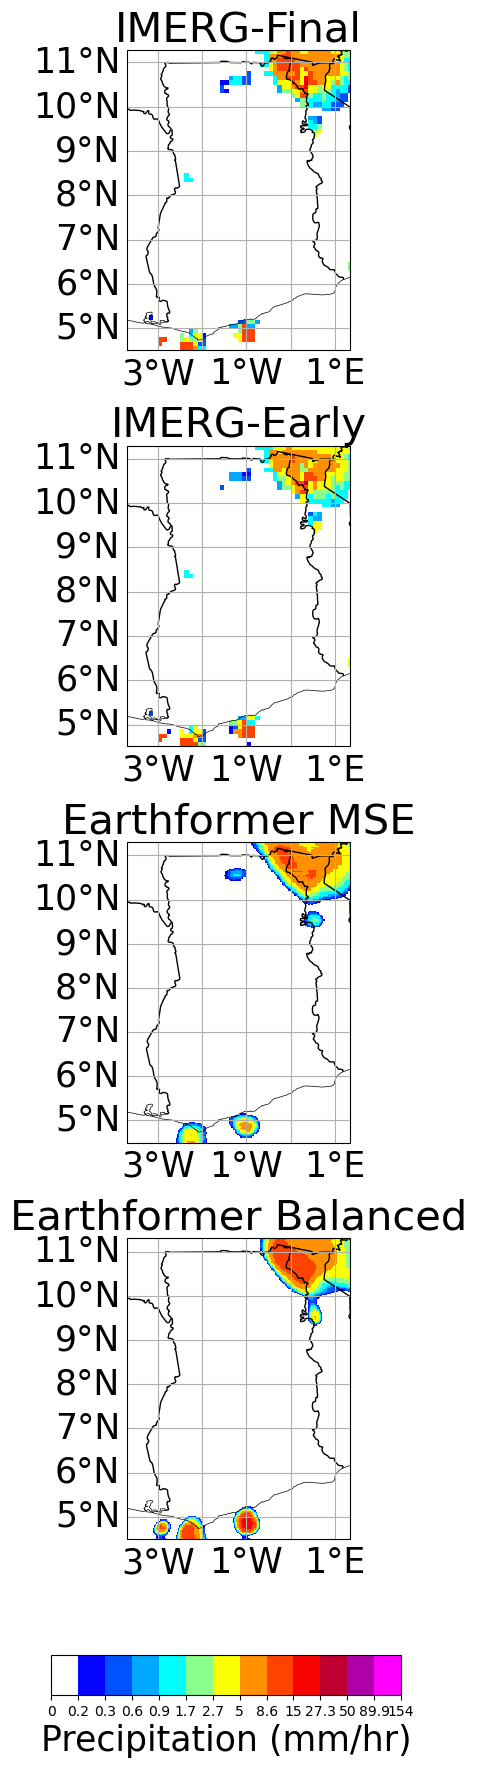

In [21]:
# Example usage
plot_precip_comparison_single(
    model_dir="D:/Ghana/Output_data/experiments_adapted121/repotest/testOutput",
    model_dir2="D:/Ghana/Output_data/experiments_adapted131/repotest/testOutput",
    imerg_final_dir="D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR",
    imerg_early_dir= "D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER",
    date="20200517",
    hour=10,
    version_early='B',
    lat_bounds=(np.min(lat_model), np.max(lat_model)),
    lon_bounds=(np.min(lon_model), np.max(lon_model))
)

D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR\2022/04/24\3B-HHR.MS.MRG.3IMERG.20220424-S170000-E172959.1020.V07B.HDF5
D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER\2022/04/24\3B-HHR-E.MS.MRG.3IMERG.20220424-S170000-E172959.1020.V06B.HDF5
D:/Ghana/Output_data/experiments_adapted121/repotest/testOutput\Combined_20220424172959.h.h5
D:/Ghana/Output_data/experiments_adapted131/repotest/testOutput\Combined_20220424172959.h.h5


C:\Users\c.kwa\AppData\Local\Temp\ipykernel_14788\2129800429.py:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


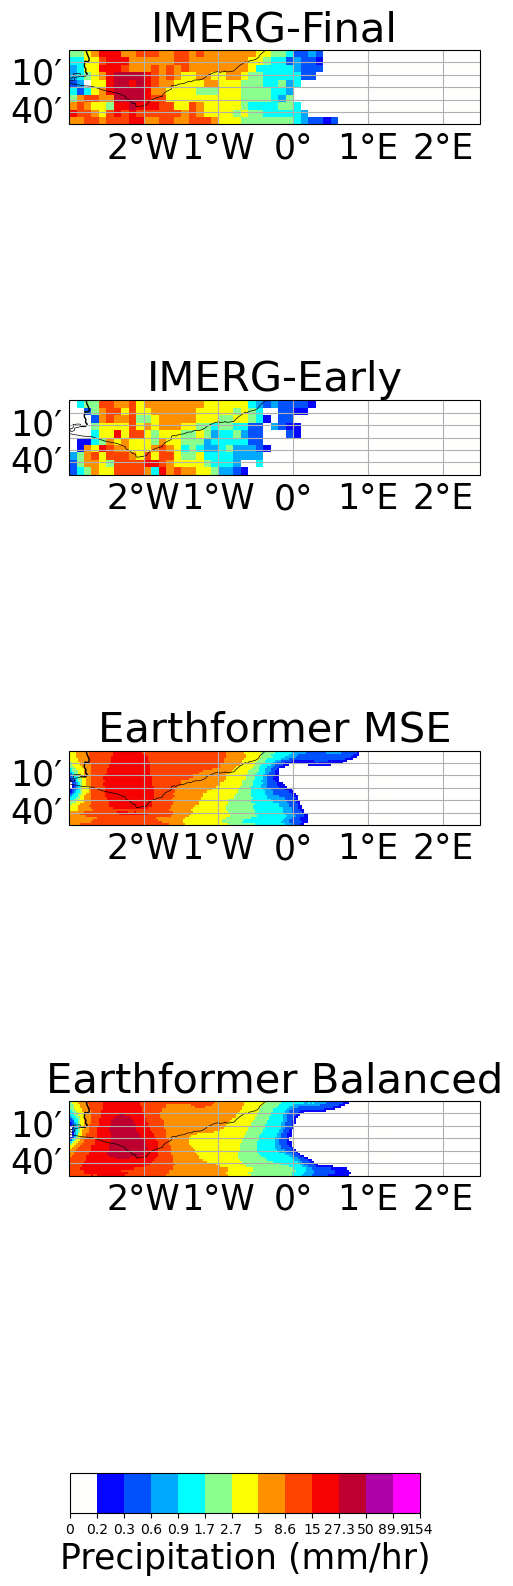

In [14]:
# Example usage
plot_precip_comparison_single_halfhour(
    model_dir="D:/Ghana/Output_data/experiments_adapted121/repotest/testOutput",
    model_dir2="D:/Ghana/Output_data/experiments_adapted131/repotest/testOutput",
    imerg_final_dir="D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR",
    imerg_early_dir="D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER",
    date="20220424",
    hour=17,
    version_early='B',
    lat_bounds=(4.5, 5.5), #(np.min(lat_model), np.max(lat_model)),
    lon_bounds= (-3, 2.5) #(np.min(lon_model), np.max(lon_model))
)

C:\Users\c.kwa\AppData\Local\Temp\ipykernel_14796\135628908.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


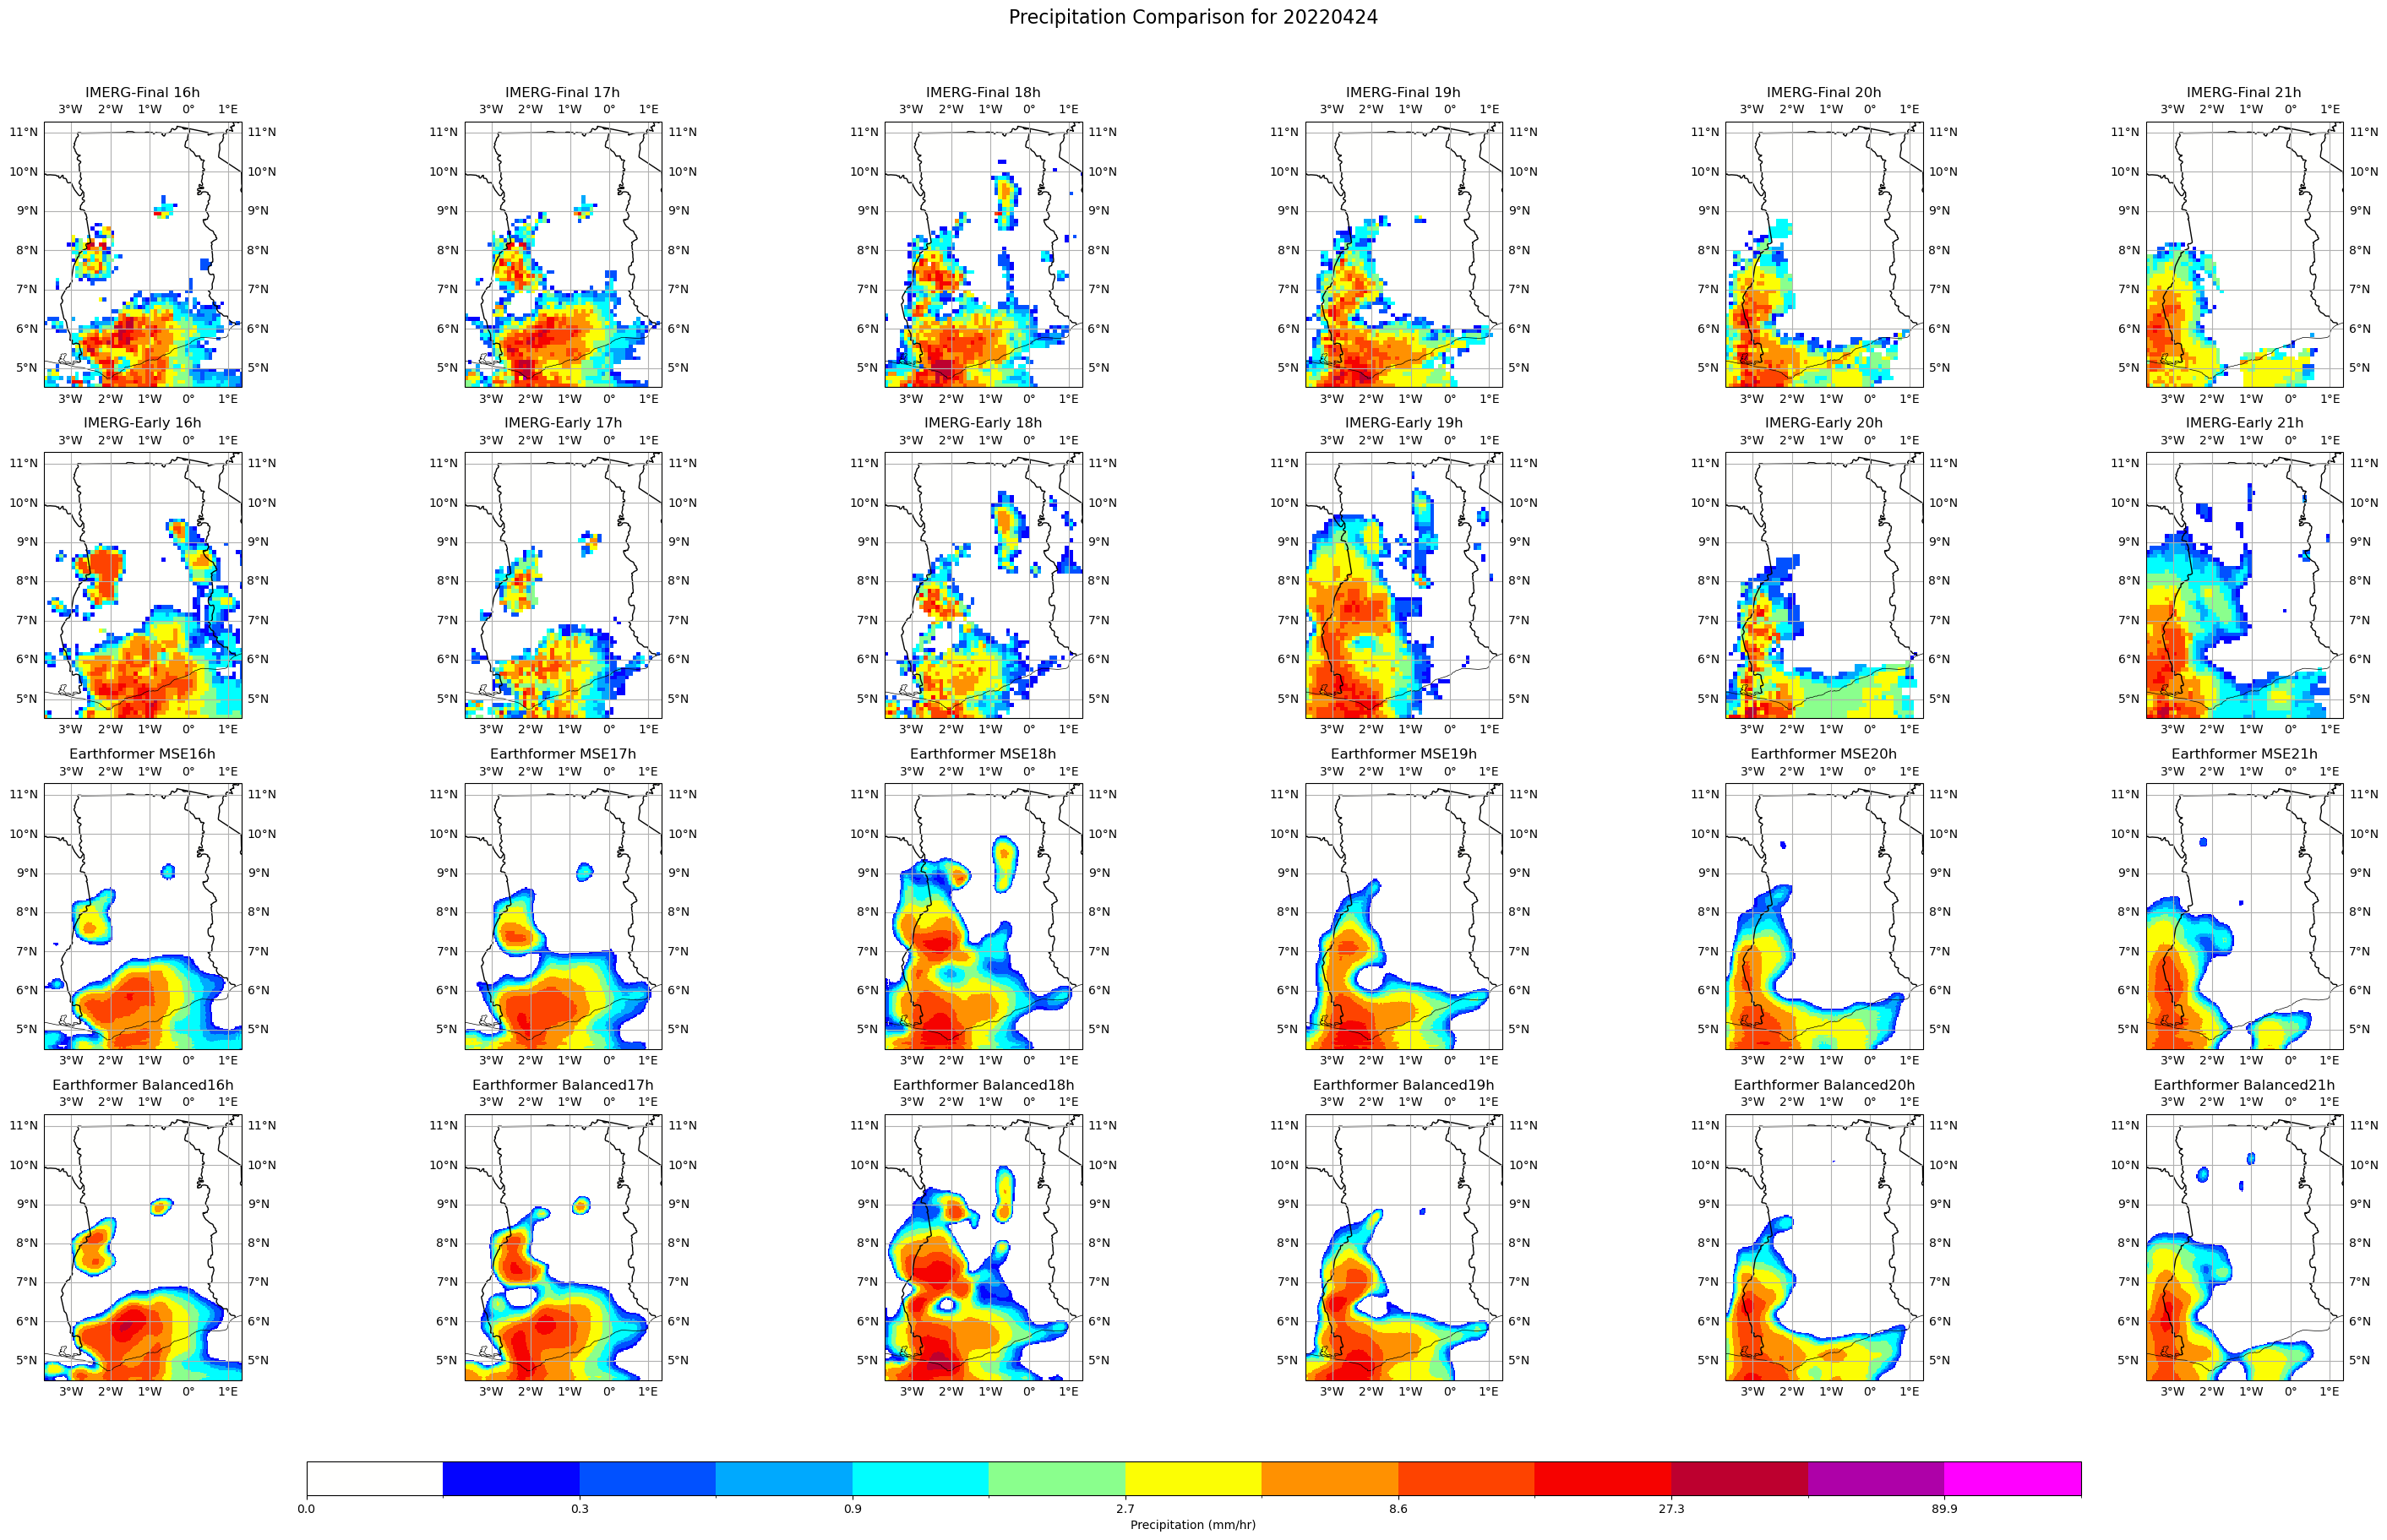

In [14]:
# Example usage
plot_precip_comparison_full(
    model_dir="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted129/repotest/testOutput",
    model_dir2="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted130/repotest/testOutput",
    imerg_final_dir="D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR",
    imerg_early_dir="D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER",
    date="20220424",
    time_range=(16, 21),
    version_early = 'B',
    lat_bounds=(np.min(lat_model), np.max(lat_model)),  # Replace with desired latitude bounds
    lon_bounds=(np.min(lon_model), np.max(lon_model))  # Replace with desired longitude bounds
    
)

D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR\2022/10/07\3B-HHR.MS.MRG.3IMERG.20221007-S143000-E145959.0870.V07B.HDF5
D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER\2022/10/07\3B-HHR-E.MS.MRG.3IMERG.20221007-S143000-E145959.0870.V06C.HDF5
D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR\2022/10/07\3B-HHR.MS.MRG.3IMERG.20221007-S153000-E155959.0930.V07B.HDF5
D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER\2022/10/07\3B-HHR-E.MS.MRG.3IMERG.20221007-S153000-E155959.0930.V06C.HDF5
D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR\2022/10/07\3B-HHR.MS.MRG.3IMERG.20221007-S163000-E165959.0990.V07B.HDF5
D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER\2022/10/07\3B-HHR-E.MS.MRG.3IMERG.20221007-S163000-E165959.0990.V06C.HDF5


C:\Users\c.kwa\AppData\Local\Temp\ipykernel_22876\2831672684.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


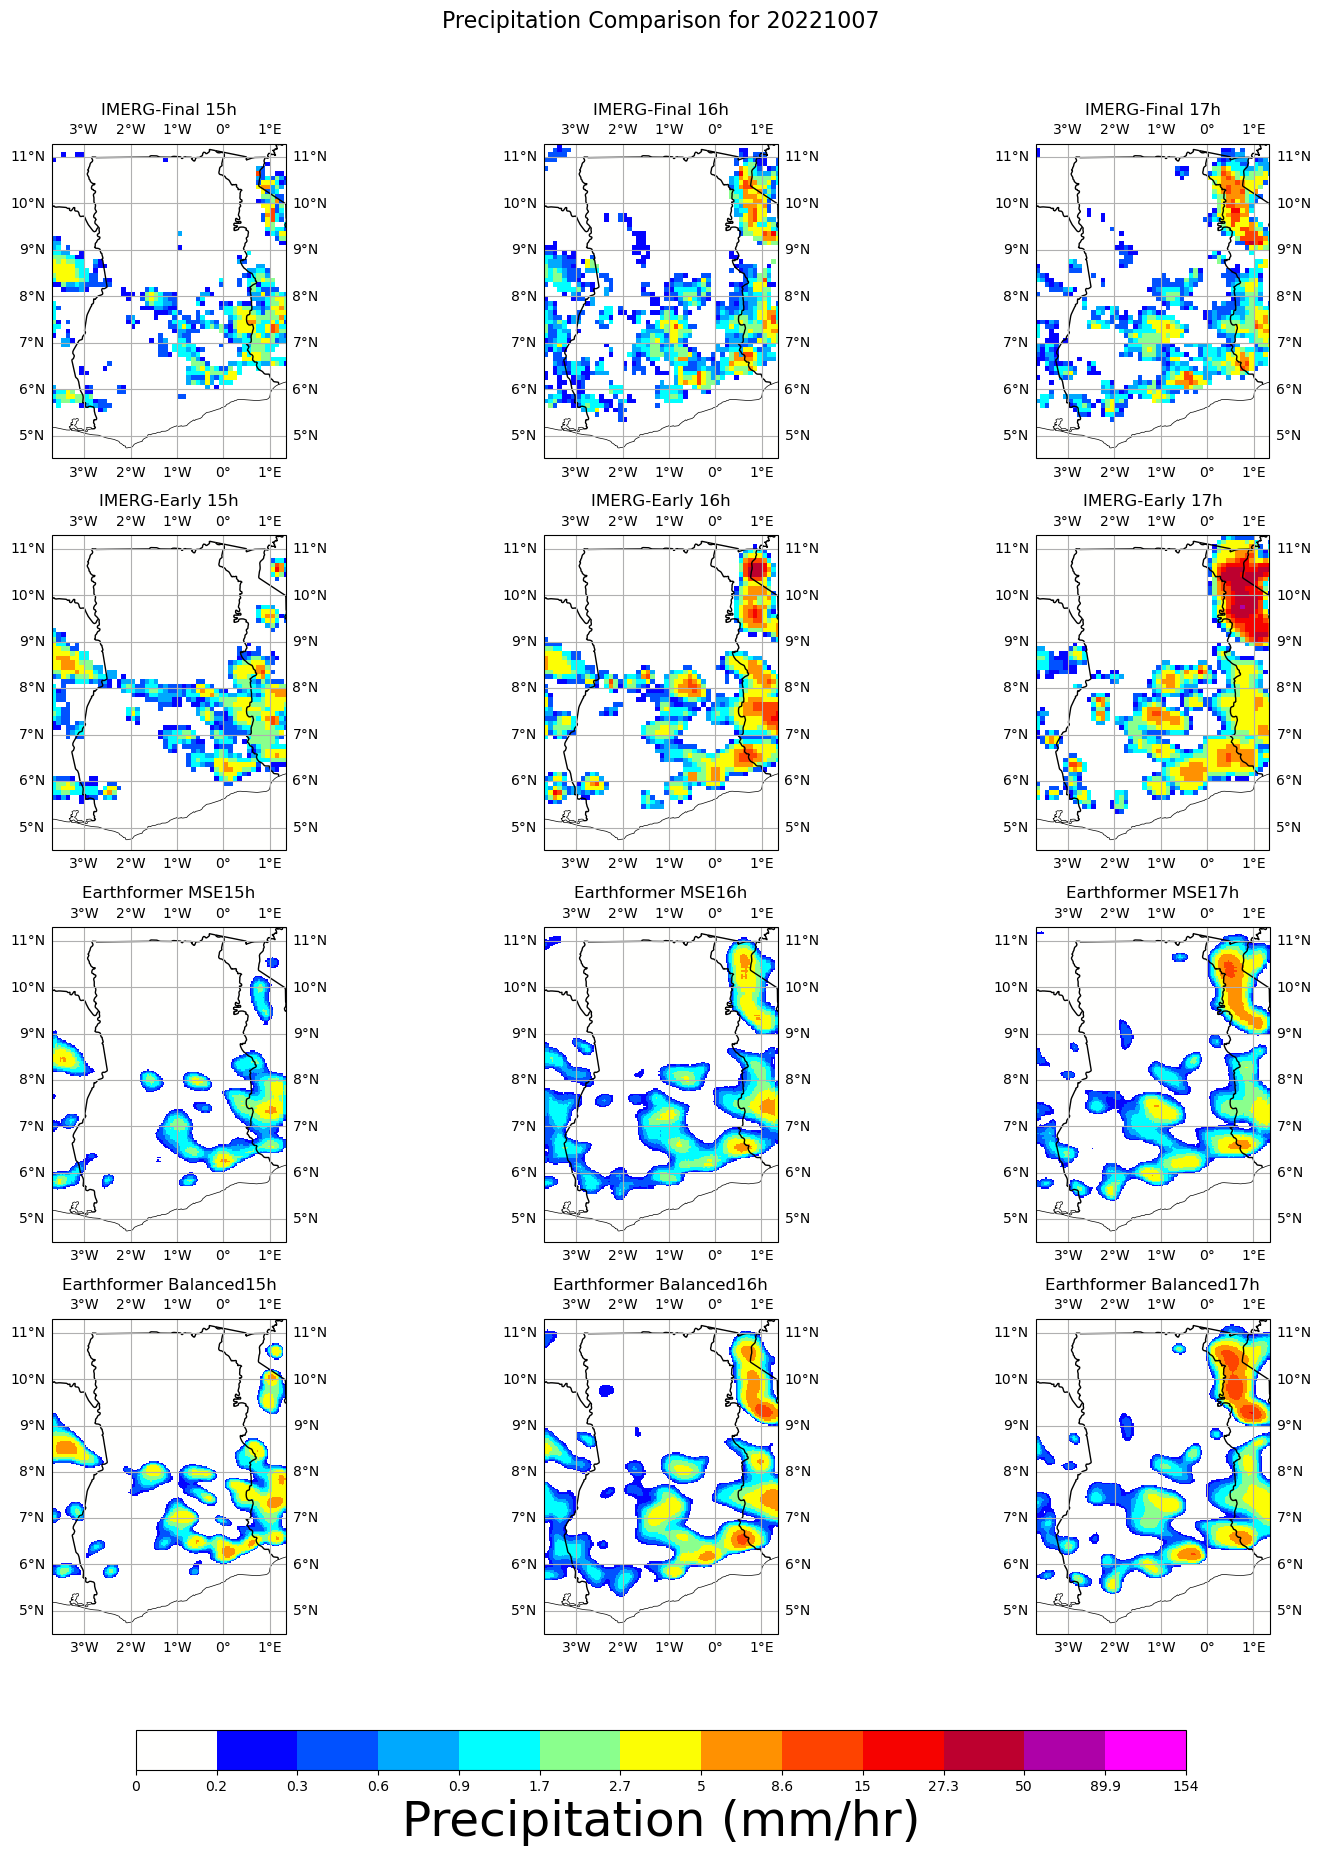

In [14]:
# Example usage
plot_precip_comparison_full(
    model_dir= "D:/Ghana/Output_data/experiments_adapted129/repotest/testOutput", # "Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted129/repotest/testOutput",
    model_dir2= "D:/Ghana/Output_data/experiments_adapted130/repotest/testOutput", # "Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted130/repotest/testOutput",
    imerg_final_dir="D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR",
    imerg_early_dir="D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER",
    date="20221007",
    time_range=(15, 17),
    version_early = 'C',
    lat_bounds=(np.min(lat_model), np.max(lat_model)),  # Replace with desired latitude bounds
    lon_bounds=(np.min(lon_model), np.max(lon_model))  # Replace with desired longitude bounds
    
)

C:\Users\c.kwa\AppData\Local\Temp\ipykernel_14796\135628908.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


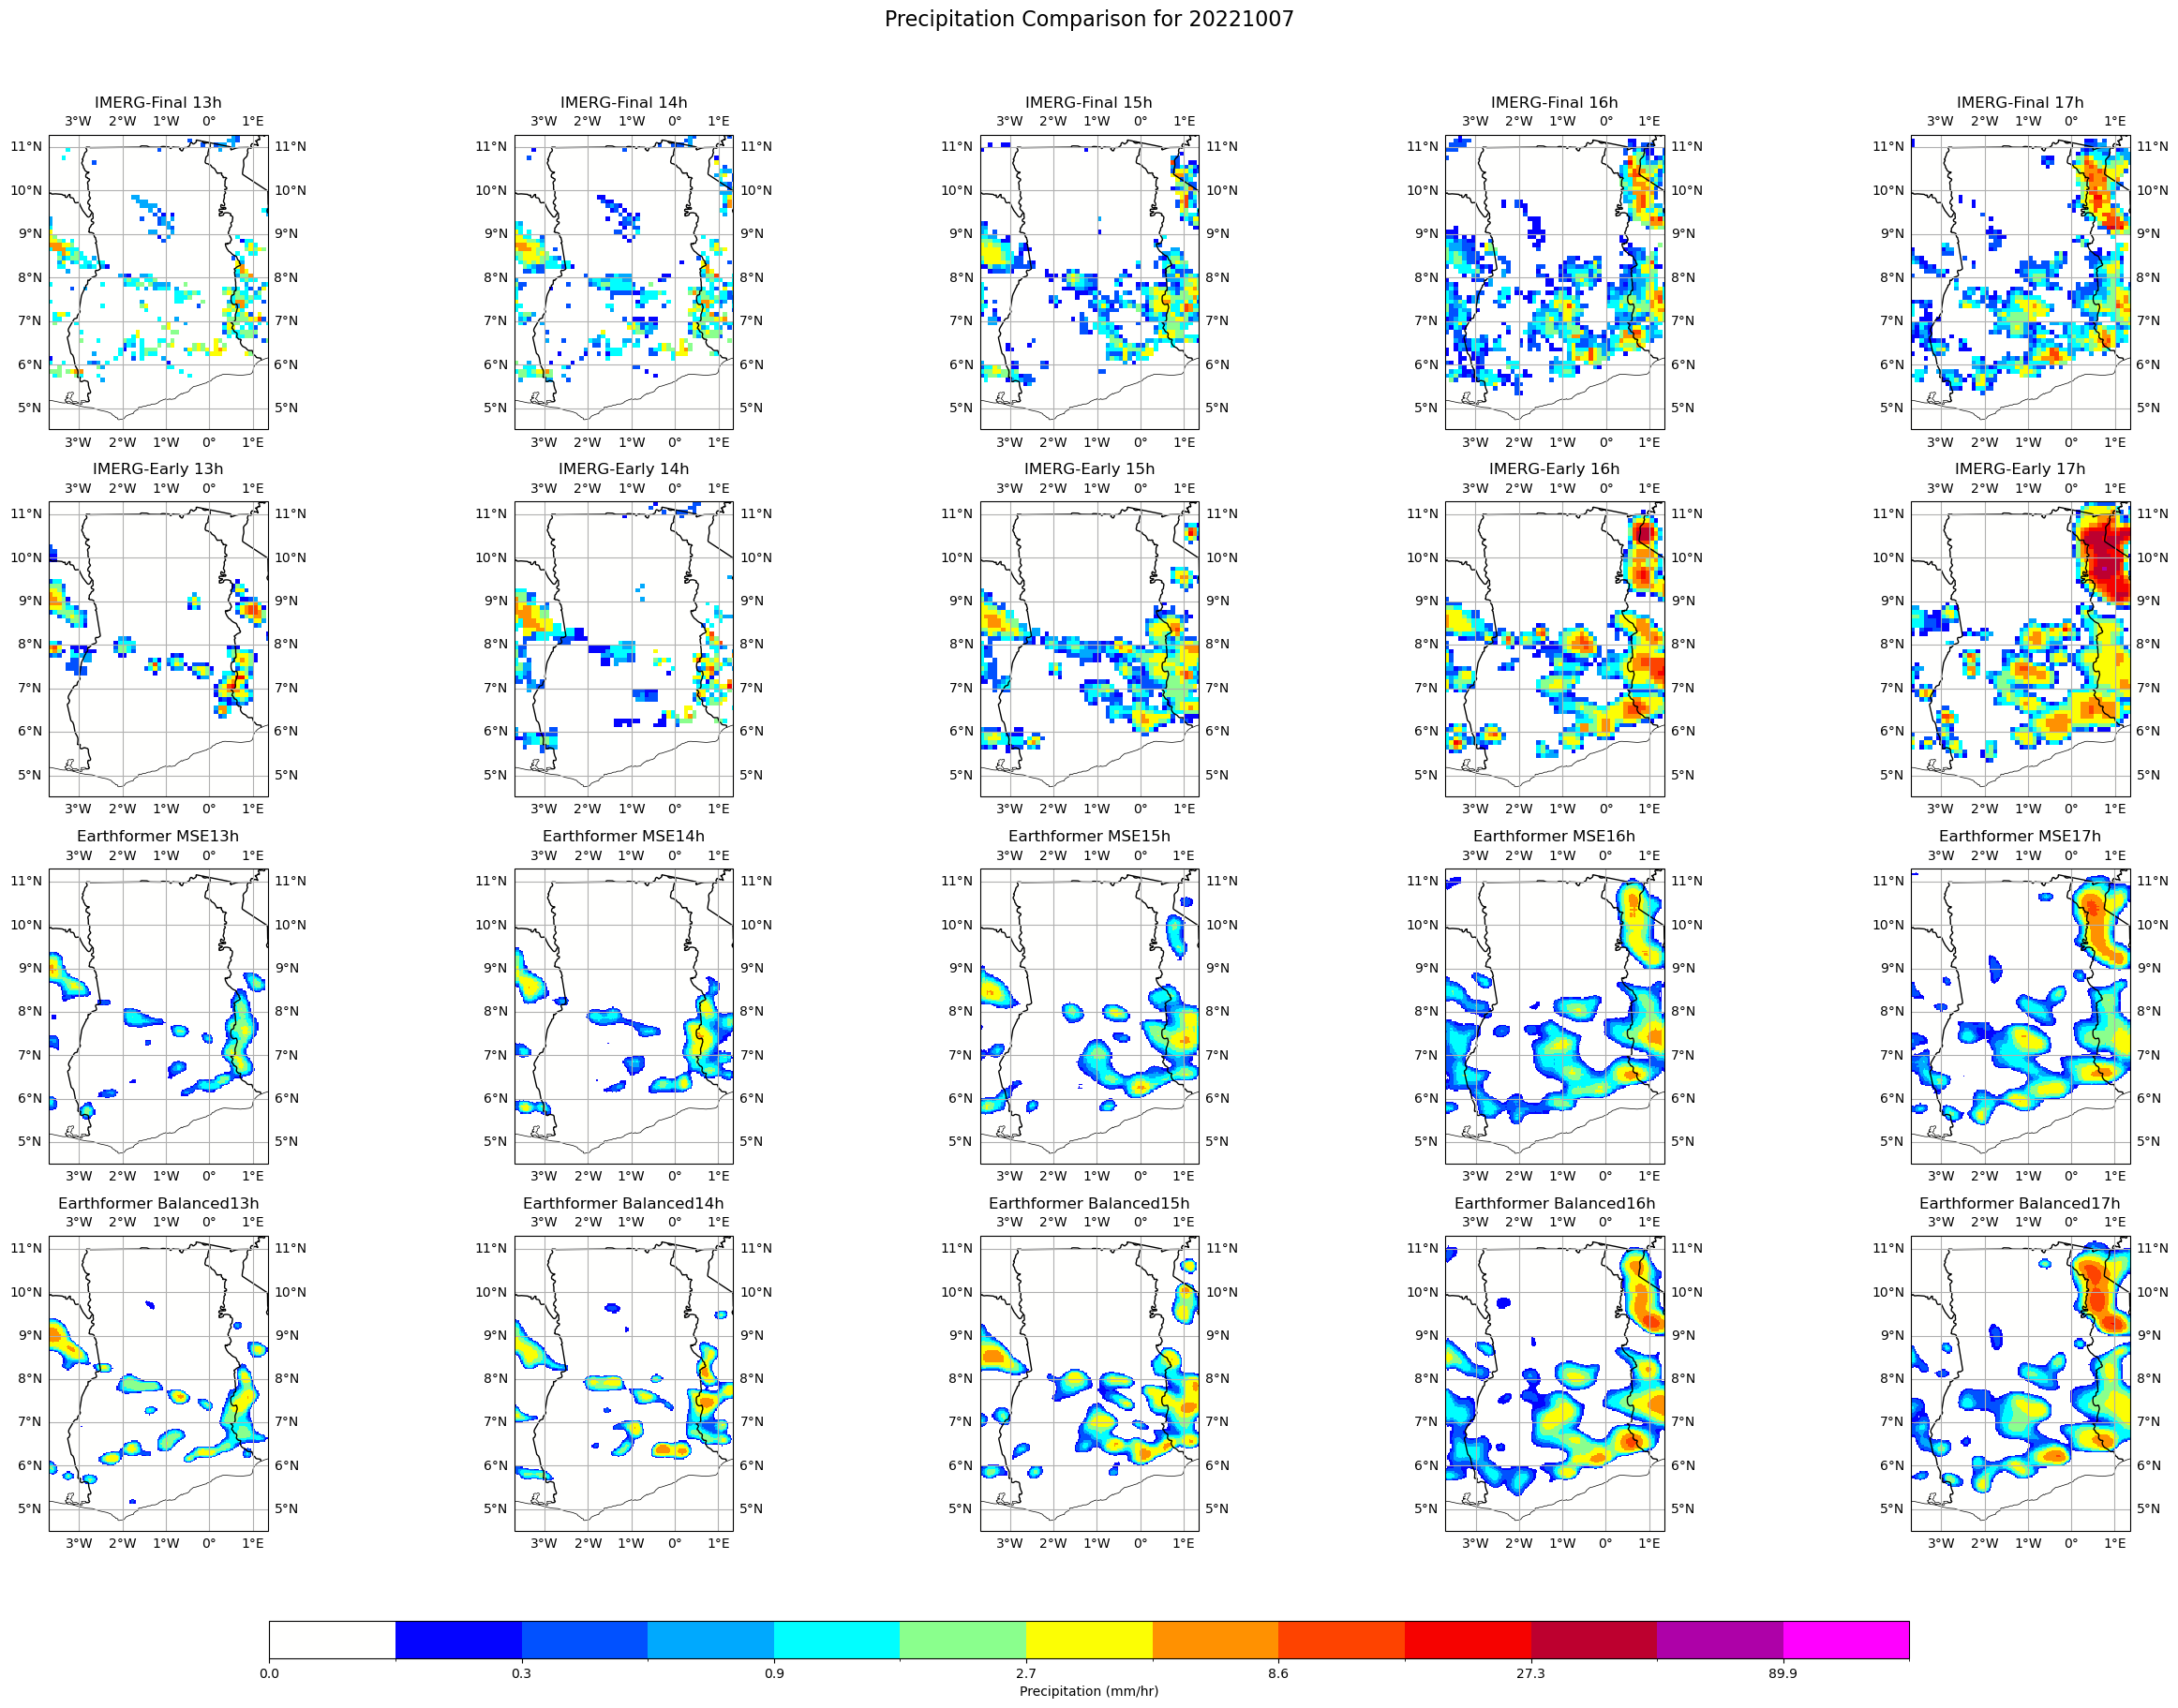

In [17]:
# Example usage
plot_precip_comparison_full(
    model_dir="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted129/repotest/testOutput",
    model_dir2="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted130/repotest/testOutput",
    imerg_final_dir="D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR",
    imerg_early_dir="D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER",
    date="20221007",
    time_range=(13, 17),
    version_early = 'C',
    lat_bounds=(np.min(lat_model), np.max(lat_model)),  # Replace with desired latitude bounds
    lon_bounds=(np.min(lon_model), np.max(lon_model))  # Replace with desired longitude bounds
    
)

C:\Users\c.kwa\AppData\Local\Temp\ipykernel_14796\135628908.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


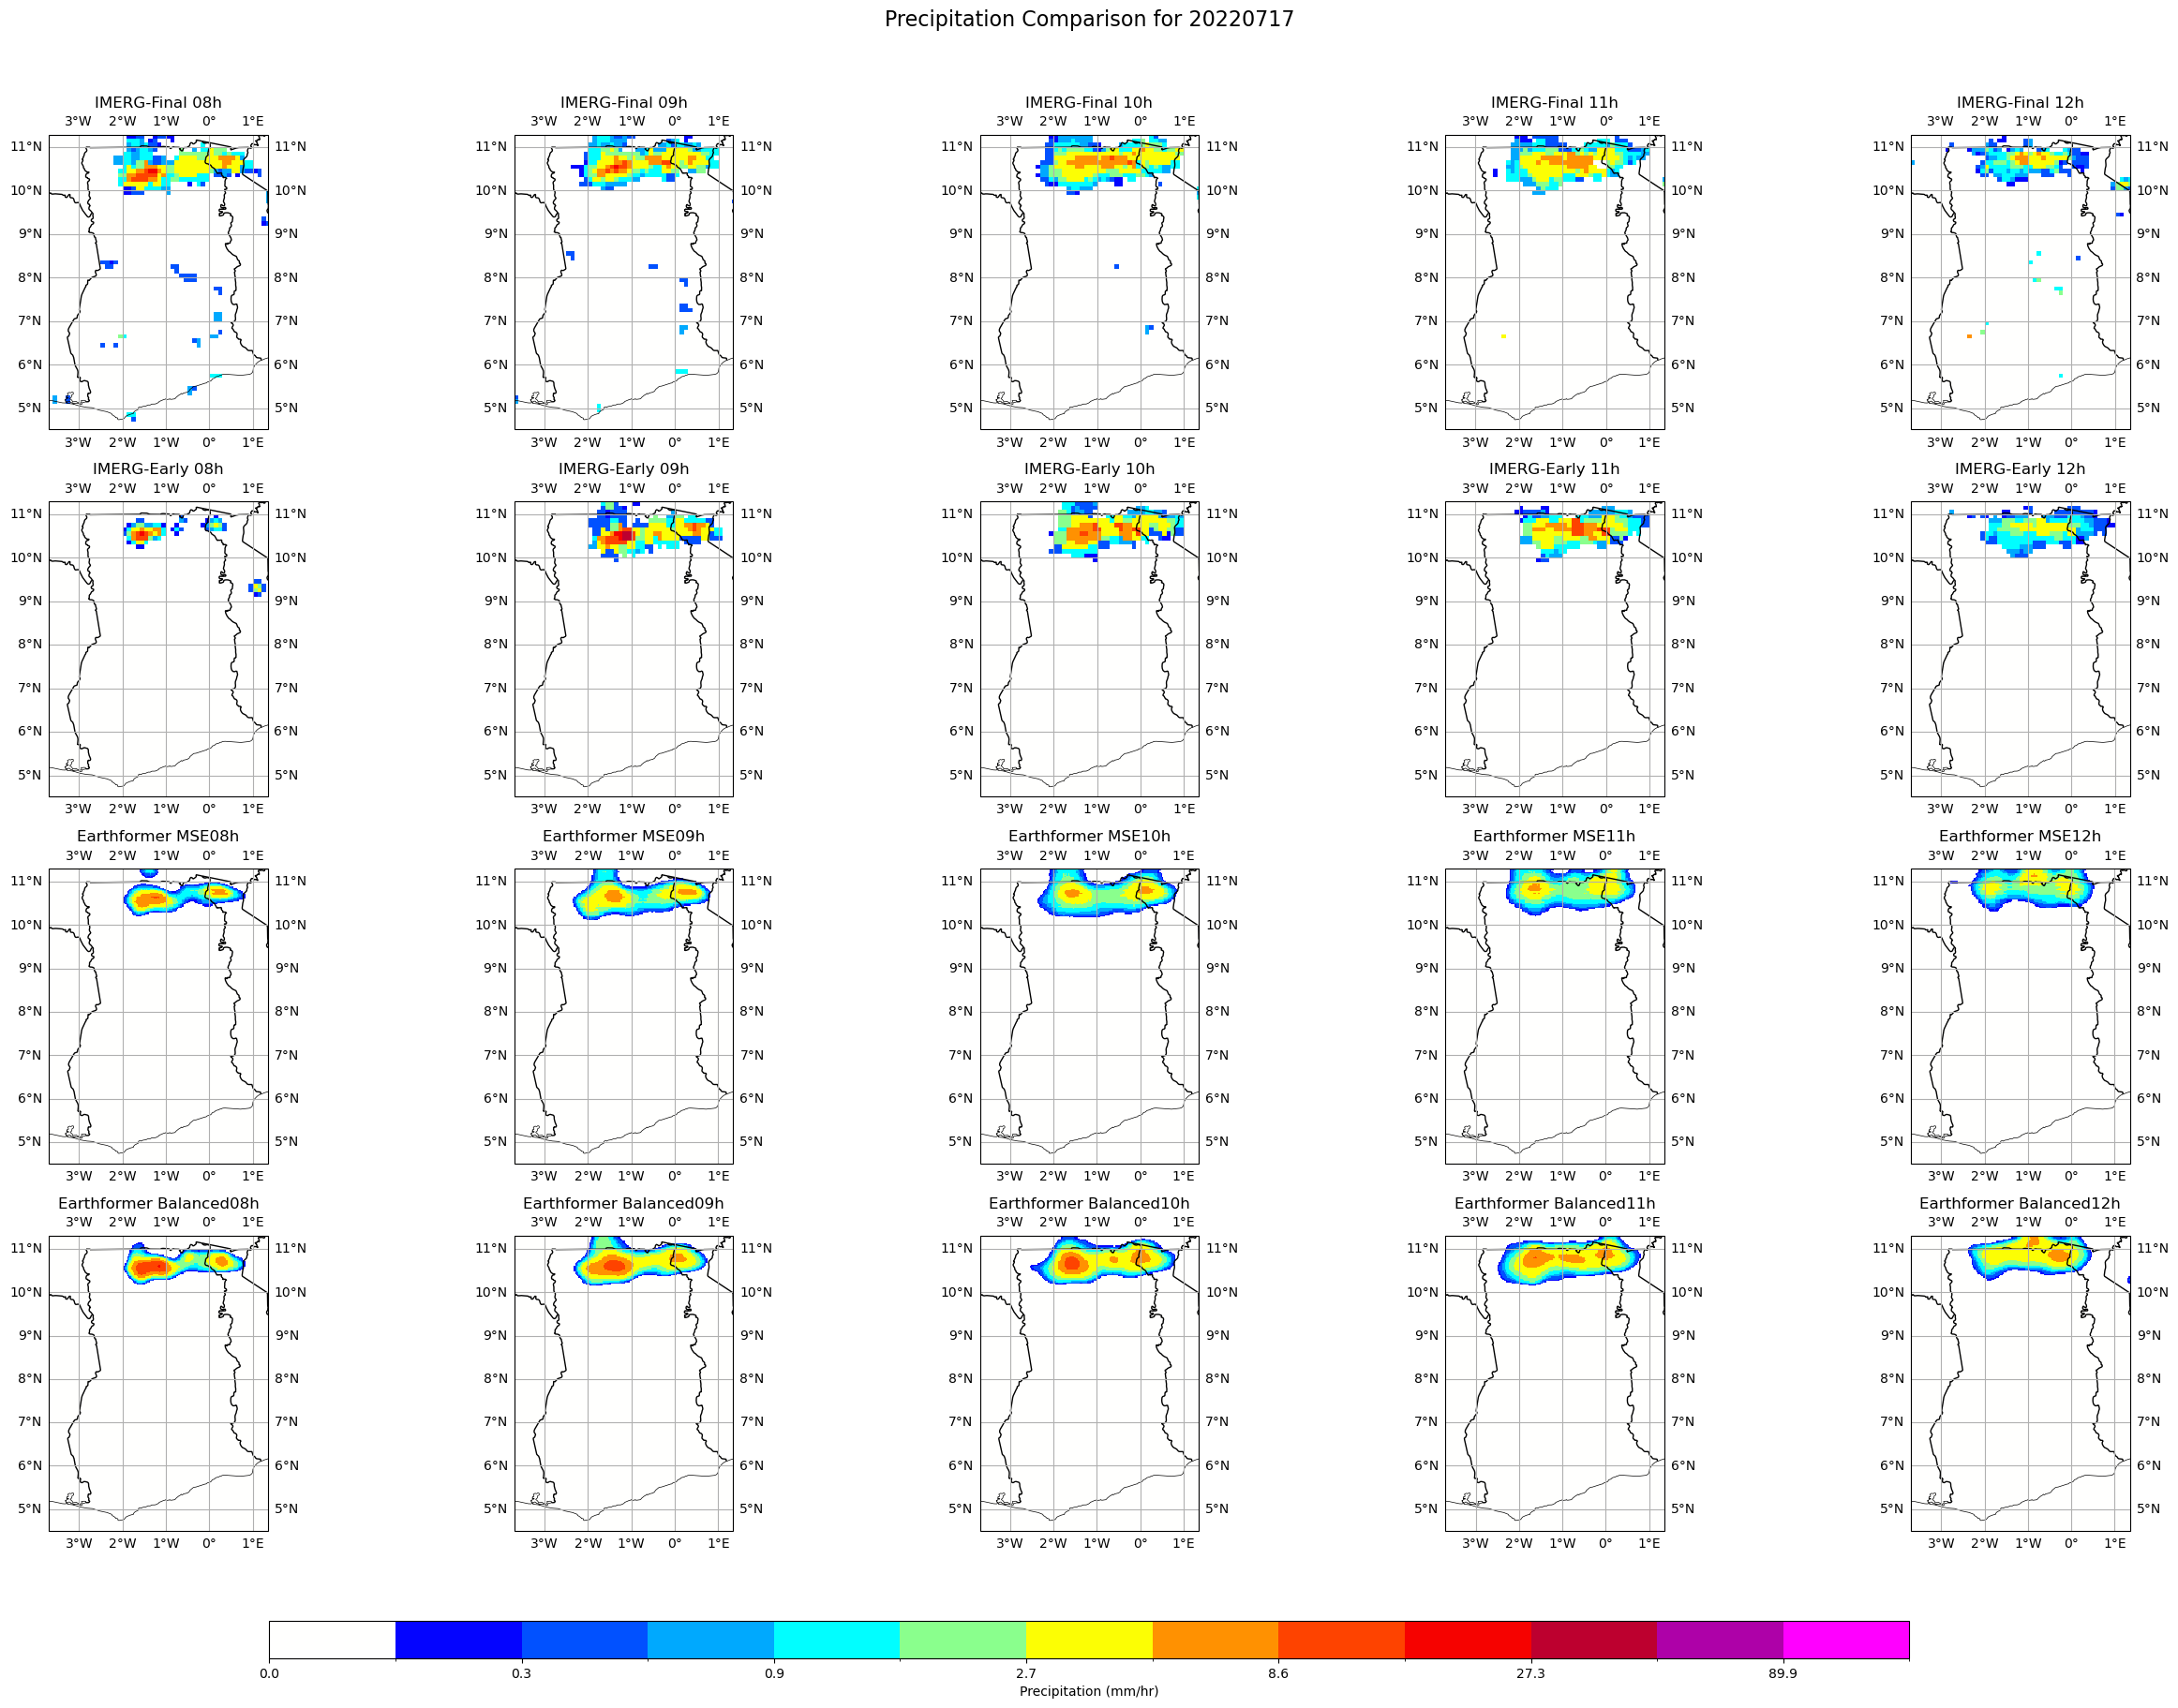

In [18]:
# Example usage
plot_precip_comparison_full(
    model_dir="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted129/repotest/testOutput",
    model_dir2="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted130/repotest/testOutput",
    imerg_final_dir="D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR",
    imerg_early_dir="D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER",
    date="20220717",
    time_range=(8, 12),
    version_early = 'C',
    lat_bounds=(np.min(lat_model), np.max(lat_model)),  # Replace with desired latitude bounds
    lon_bounds=(np.min(lon_model), np.max(lon_model))  # Replace with desired longitude bounds
    
)

C:\Users\c.kwa\AppData\Local\Temp\ipykernel_596\353704936.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


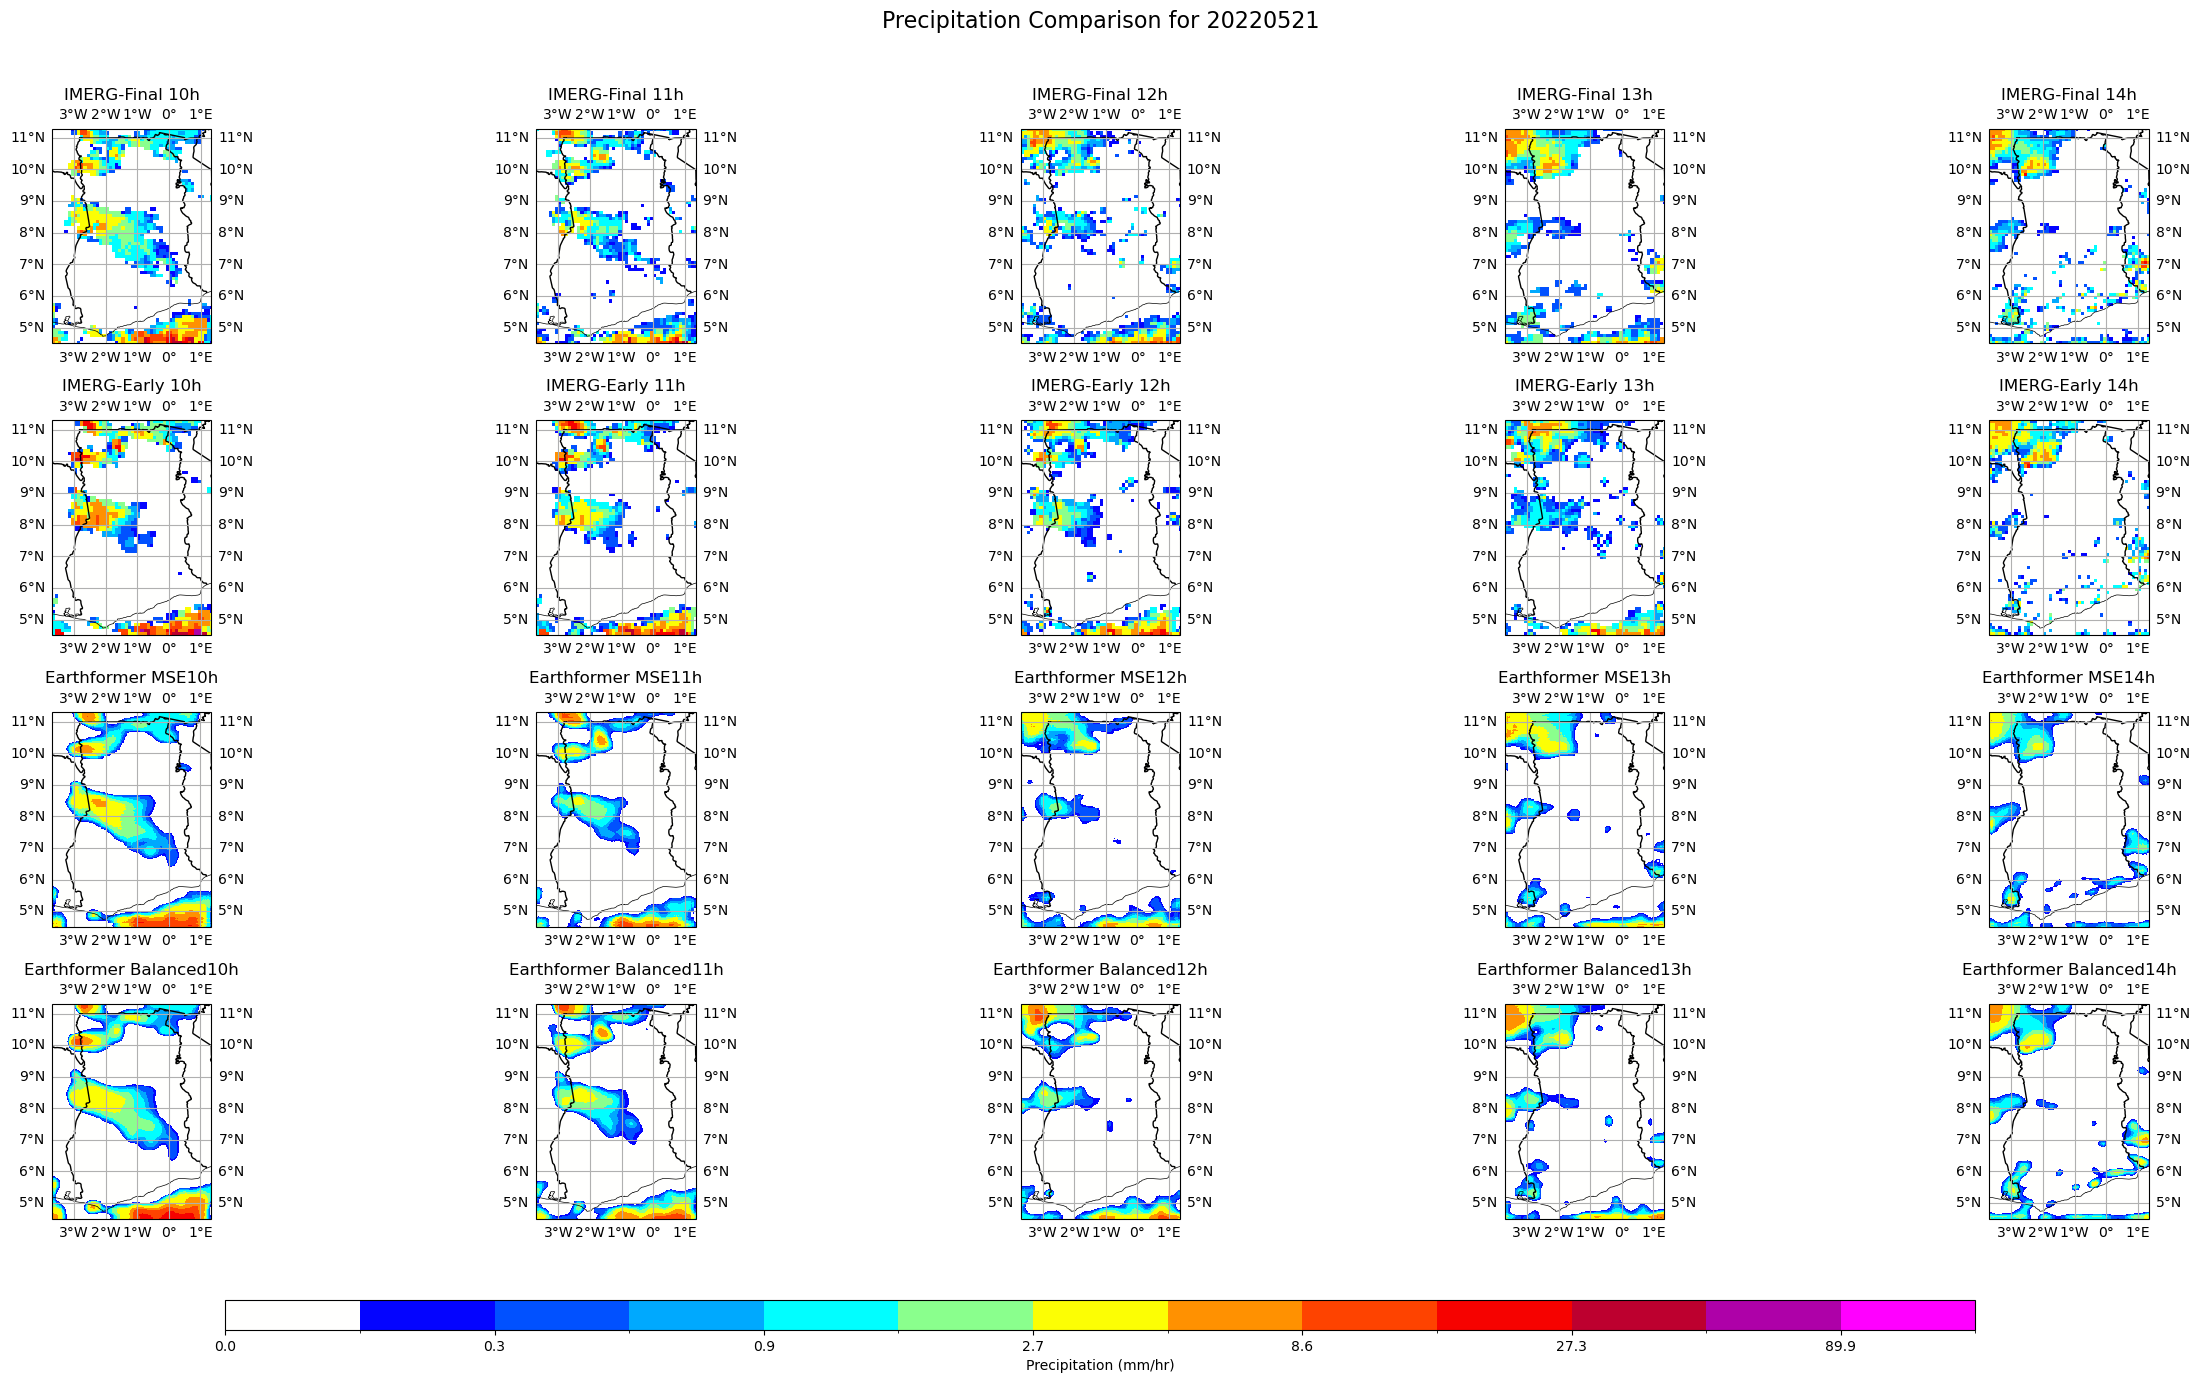

In [25]:
# Example usage
plot_precip_comparison_full(
    model_dir="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted129/repotest/testOutput",
    model_dir2="Z:/cluster_projects/ro/1149_10/earthformer-multisource-to-inca/experiments_adapted130/repotest/testOutput",
    imerg_final_dir="D:/Ghana/IMERG_data/GPM/RS/V07/IMERG/IMERG-FR",
    imerg_early_dir="D:/Ghana/IMERG_data/GPM/NRT/IMERG/IMERG-ER",
    date="20220521",
    time_range=(10, 14),
    version_early = 'C',
    lat_bounds=(np.min(lat_model), np.max(lat_model)),  # Replace with desired latitude bounds
    lon_bounds=(np.min(lon_model), np.max(lon_model))  # Replace with desired longitude bounds
    
)